# Flight delays prediction

<img src="plane_2.jpg" alt="Plane taking off">

# Introduction

This analysis of flight delays is based on [Terminal 1 assesment work](https://hackmd.io/s/SyXikdg_g#Flight-Delay-Prediction).

The objective of this challenge is to predict the amount that will be claimed on delayed flights. We will here predict the the probability of claim then allocate an optimal amount to cover the claim based on prediction.

The analysis in this notebook will:
  - prepare necessary libraries and the data set
  - explore
  - cleanse
  - add external data
  - model to predict
  - prepare a self-service predictor
  - prepare an online predictor

The end-to-end work will be done using Python. As a common data-science tool, Python will help all the analysis and modelling. In addition, we will put the model online using Flask, which is also based on Python. Implementation in production will therefore be easier.

# Important notes to read before running this notebook

1. You will see multiple **<font color='red'>Exceptions</font>** and **<font color='red'>ValueError</font>** when running the notebook. Please **<font color='green'>ignore them</font>**. These are none issues of Pandas but will not impact the output results.
2. You can **run your own predictions** at the end of the notebook. Run the entire notebook before and then use the very last cell.
3. **Running the notebook will take time**. The Random Forest in particular will take several minutes. The more powerful your computer, the better. Several cells that are not mandatory have been commented to gain time.

# Preparation, analysis and feature engineering

## Preparation

### Libraries importation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

import re
import os
import math
import codecs

import folium # to draw maps
import branca.colormap as cm

import pickle # to export the model in the web app

%matplotlib inline

### Dataset importation

[Link](https://www.dropbox.com/s/6marc0211lp4kg5/flight_delays_data.zip?dl=1) to the dataset.

In [2]:
flights = pd.read_csv("flight_delays_data.csv")

## Exploration

### Initial analysis

In [3]:
flights.shape

(899114, 10)

In [4]:
flights.head(10)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0
5,1582511,NZ4851,10,HKG,IST,NZ,23,0.2,2015-03-10,0
6,1582512,CX5626,51,HKG,HGH,CX,7,0.4,2015-12-19,0
7,1582513,MH9725,8,HKG,KUL,MH,12,0.1,2014-02-23,0
8,1582516,KA154,42,HKG,BLR,KA,21,0.0,2014-10-21,0
9,1582517,CX233,10,HKG,MXP,CX,0,0.3,2015-03-05,0


Almost 900,000 records with 10 features.

Mix of categorical, numerical and binary variables. Need to clean the whole.

Dataset is quite large for one single machine. Training stage may take time notably with grid search for hyperparameter tunning.

In [5]:
flights.describe().T # look at numerical variables.

,count,mean,std,min,25%,50%,75%,max
flight_id,899114.0,1.397967e+06,806290.111875,4.0,699092.5,1399353.5,2096360.75,2793516.0
Week,899114.0,2.602171e+01,15.248474,1.0,13.0,25.0,40.00,52.0
std_hour,899114.0,1.402770e+01,5.530994,0.0,10.0,15.0,18.00,23.0
is_claim,899114.0,3.506830e+01,163.783041,0.0,0.0,0.0,0.00,800.0


Too early to comment.

Delay time is not in the numerical variables. We need to look at it.

In [6]:
flights.nunique()

flight_id      899114
flight_no        2344
Week               52
Departure           1
Arrival           163
Airline           122
std_hour           24
delay_time        379
flight_date      1065
is_claim            2
dtype: int64

Arrivals and airlines have a high number of possible values, which may be problematic when training the model as they are categorical and will be converted as dummy variables, 1 column per dummy variables.

Other fields with large values are just ID's.

Hong Kong is the only departure, so this field will not bring value for the model except to calculate the distance to destination.

In [7]:
flights_columns = flights.columns # list of features
flights_columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim'],
      dtype='object')

In [8]:
flights.dtypes

flight_id       int64
flight_no      object
Week            int64
Departure      object
Arrival        object
Airline        object
std_hour        int64
delay_time     object
flight_date    object
is_claim        int64
dtype: object

**Note**: changes to bring  
  - flight_id      categorical
  - flight_no      categorical
  - Week           categorical
  - Departure      categorical
  - Arrival        categorical
  - Airline        categorical
  - std_hour       int8
  - delay_time     float64
  - flight_date    date
  - is_claim       categorical

### Null values

In [9]:
flights.isnull().sum()/flights.shape[0]*100

flight_id      0.000000
flight_no      0.000000
Week           0.000000
Departure      0.000000
Arrival        0.000000
Airline        0.190632
std_hour       0.000000
delay_time     0.000000
flight_date    0.000000
is_claim       0.000000
dtype: float64

The dataset is pretty clean. Only Airline has null values, accounting for 0.2% of the whole. We will fill them with the most frequent.

In [10]:
# search the most frequent value within 'Airline' to replace the Null values
flights['Airline'].mode()[0]

'CX'

Most frequent airline is CX: Cathay Pacific, which is coherent as the main Hong Kong airline.

In [11]:
flights['Airline'].fillna(flights['Airline'].mode()[0], inplace=True)

In [12]:
flights.isnull().sum()/flights.shape[0]*100 # check that there is no more Null values.

flight_id      0.0
flight_no      0.0
Week           0.0
Departure      0.0
Arrival        0.0
Airline        0.0
std_hour       0.0
delay_time     0.0
flight_date    0.0
is_claim       0.0
dtype: float64

#### Changing types

In [13]:
# changing types as per note above

# categories
flights['flight_no'] = flights['flight_no'].astype('category')
flights['Week'] = flights['Week'].astype('category')
flights['Arrival'] = flights['Arrival'].astype('category')
flights['Airline'] = flights['Airline'].astype('category')
flights['is_claim'] = flights['is_claim'].astype('category')

# numerical
flights['std_hour'] = flights['std_hour'].astype('int8')

#### Specific features

Let's look at **delay_time**.

In [14]:
flights['delay_time'].value_counts()[0:10]

0.0          110812
0.1          108989
0.3           96432
0.2           92152
0.4           89916
0.5           68588
-0.1          62678
0.6           49485
0.7           35056
Cancelled     25692
Name: delay_time, dtype: int64

There is a 'Cancelled' value which is not numeric. We will create:
  - a 'cancelled' field indicating cancelled flights. 
  - a 'delay_time_num' where 'cancelled' values will be replaced by Null values.

Theses feilds will not be in our model (that would be information leaking leading to 100% accuracy!). We thus do not need to handle the Null values before modelling.

In [15]:
def cancelled_plane(x):
    """create new 'cancelled' values"""
    if (x == 'Cancelled'):
        return 1
    else:
        return 0
    
def clean_delay(time):
    """Create a numerical delay_time_num feature by setting "cancelled" as a NaN"""
    if (time != 'Cancelled'):
        return time
    return np.nan

In [16]:
flights['cancelled'] = flights['delay_time'].apply(cancelled_plane) # create cancelled feature
flights['cancelled'] = flights['cancelled'].astype('category') # convert to categorical

flights['delay_time_num'] = flights['delay_time'].apply(clean_delay) # replace 'Cancelled' by Null values
flights['delay_time_num'] = flights['delay_time_num'].astype('float') # convert to numerial

Let's look at **is_claim**, which is our target.

Claimed: 4.38% flights leads to a claim, that is to say is delayed by more than 3 hours or cancelled.


0      859701
800     39413
Name: is_claim, dtype: int64

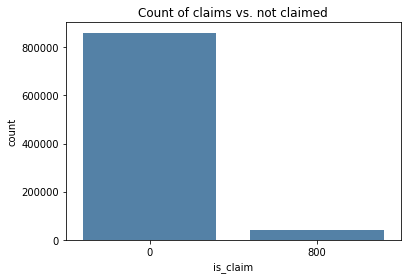

In [17]:
sns.countplot(x='is_claim',data=flights, color = 'steelblue')
fig = plt.title("Count of claims vs. not claimed")
print("Claimed: {:3.2f}% flights leads to a claim, that is to say is delayed by more than 3 hours or cancelled.".
      format(((flights['is_claim'] == 800)*1).mean()*100))

flights['is_claim'].value_counts() # numerical view of the counts

The feature is cleaned but imbalanced. We may suffer from overprediction of 'not claimed'.

## Analysis with feature engineering and addition of new features

### Arrival locations

We will add the latitude, longitude and distance (from Hong Kong) for analysis and possible explanatory variables.

This data will also avoid to have one dummy field for each destination and thus speed up processing later on.

#### Import airports data

Link to [airports.csv](https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat) on [OpenFlights.org](https://openflights.org/data.html). You have to copy paste the data into a csv.

In [18]:
# prepare airports DataFrame
airports_col_names = ['name','country','airport_code','latitude','longitude']
with codecs.open('airports.csv', "r",encoding='utf-8', errors='ignore') as flights_source:
    airports = pd.read_csv(flights_source, encoding = 'utf-8', header=None)
    airports.drop(columns = [0,1,5,8,9,10,11,12,13], inplace = True)
airports.columns = airports_col_names

In [19]:
airports.head()

,name,country,airport_code,latitude,longitude
0,Goroka,Papua New Guinea,GKA,-6.081690,145.391998
1,Madang,Papua New Guinea,MAG,-5.207080,145.789001
2,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005
3,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977
4,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001


#### Join airport for departure and destination

**Note**: **ValueErrors** can be ignored

In [20]:
flights['departure_latitude'] = airports[airports['airport_code'] == 'HKG']['latitude'].values[0]
flights['departure_longitude'] = airports[airports['airport_code'] == 'HKG']['longitude'].values[0]

flights = flights.merge(airports, left_on='Arrival', right_on='airport_code', how = 'inner')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


In [21]:
flights.rename(columns={"latitude": "arrival_latitude", "longitude": "arrival_longitude"}, inplace = True)

#### Calculate distance between Hong Kong and destination

In [22]:
from math import sin, cos, sqrt, atan2, radians

def lat_long_distance(dep_lat, dep_long, arr_lat, arr_long):
    """function to calculte the distance between 2 points on Earth based on latitude and longitude
    input: latitude and longitude
    output: distance in km"""   
    R = 6371.0 # Earth radius in km
    dep_lat = radians(dep_lat)
    dep_long = radians(dep_long)
    arr_lat = radians(arr_lat)
    arr_long = radians(arr_long)
    longitude = arr_long - dep_long
    latitude = arr_lat - dep_lat
    a = sin(latitude / 2)**2 + cos(dep_lat) * cos(arr_lat) * sin(longitude / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

We will create a dictionary that which stores the distance to each location, the origin being always Hong Kong.

In [23]:
airports_list = flights['Arrival'].unique()
airports_list = np.append(airports_list, 'HKG').tolist()

airports_dict = {}
dep_lat = airports[airports['airport_code'] == 'HKG']['latitude'].values[0] # origin is always Hong Kong latitude
dep_long = airports[airports['airport_code'] == 'HKG']['longitude'].values[0] # origin is always Hong Kong longitude
for airport in airports_list:
    arr_lat = airports[airports['airport_code'] == airport]['latitude'].values[0] # destination latitude
    arr_long = airports[airports['airport_code'] == airport]['longitude'].values[0] # destination longitude
    airports_dict[airport] = lat_long_distance(dep_lat, dep_long, arr_lat, arr_long) # distance to Hong Kong

    
flights['distance'] = flights['Arrival'].map(airports_dict) # add 'distance' feature into flights

Let's map spread of destinations with the associated number of flights.

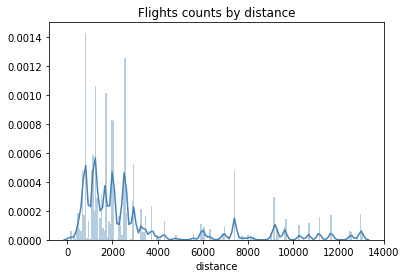

In [24]:
sns.distplot(flights['distance'], bins=200 , color ='steelblue')
fig = plt.title("Flights counts by distance")

Most flights are on a short distance around Hong Kong. Like any airport, Hong Kong is covering its surroundings and large world cities.

We will bucketize the distances for further analysis and modelling

In [25]:
def distance_group_maker(distance):
    """bucketize distance. We will try to have a rather even number of events per bucket"""
    if (distance < 1100):
        return "1:<1000"
    elif (1100 <= distance < 1600):
        return "2:1000-1599"
    elif (1600 <= distance < 2300):
        return "3:1000-2299"
    elif (2300 <= distance < 3500):
        return "4:2300-3499"
    else:
        return "5:>= 3500"

flights['distance_group'] = flights['distance'].apply(distance_group_maker)
flights['distance_group'] = flights['distance_group'].astype('category')

In [26]:
flights.groupby('distance_group').count()['flight_id']

distance_group
1:<1000        184845
2:1000-1599    151934
3:1000-2299    187014
4:2300-3499    186814
5:>= 3500      187925
Name: flight_id, dtype: int64

We have adjusted the intervals to spread the number of flights across the bins

#### Let's look at the destinations and their frequencies on a map

In [27]:
flights_map = flights[['flight_id','Arrival','arrival_latitude','arrival_longitude']]
flights_map_group = flights_map.groupby(['Arrival','arrival_latitude','arrival_longitude'])['flight_id'].agg(['count'])
flights_map = flights_map_group.reset_index()
flights_map['destination'] = flights_map['Arrival'] # index names needed for the map
flights_map.set_index('Arrival', inplace = True)

In [28]:
%matplotlib inline

this_map = folium.Map(prefer_canvas=True)
fg = folium.FeatureGroup(name="Flight destinations and frequency")
#flights_map['destination'] = flights['Arrival'] # index names needed for the map

dest = list(flights_map["destination"])
lat = list(flights_map["arrival_latitude"])
lon = list(flights_map["arrival_longitude"])
counter = list(flights_map["count"])

def color_maker(trip):
    if trip >= 20000:
        return 'red'
    elif trip > 10000 and trip <20000:
        return 'orange'
    else:
        return 'yellow'
        
for de, lt, ln, cn in zip(dest, lat, lon, counter):
    fg.add_child(folium.CircleMarker(location=[lt, ln],
                        radius=5,
                        weight=2,#remove outline
                        popup = de,
                        color=color_maker(cn),
                        fill_color=color_maker(cn)))

this_map.add_child(fg)    

#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

<h2><center>Flight destinations and frequency</center></h2>

In [29]:
this_map

  - More than <font color='red'> 20,000 </font> flights
  - More than <font color='orange'> 10,000 </font> flights
  - Less than <font color='yellow'> 10,000 </font> flights

As expected, Hong Kong is covering essentially Asia and the largest cities worlwide.

Higher frequencies destinations are large Asian cities.

#### Destinations and average delay

In [30]:
flights_map = flights[['flight_id','Arrival','arrival_latitude','arrival_longitude','delay_time_num']]
flights_map_group = flights_map.groupby(['Arrival','arrival_latitude','arrival_longitude'])['delay_time_num'].agg(['mean'])
flights_map = flights_map_group.reset_index()
flights_map['destination'] = flights_map['Arrival'] # index names needed for the map
flights_map.set_index('Arrival', inplace = True)

In [31]:
flights_map

,arrival_latitude,arrival_longitude,mean,destination
Arrival,,,,
ADD,8.977890,38.799301,0.872518,ADD
ADL,-34.945000,138.531006,0.373678,ADL
AKL,-37.008099,174.792007,0.361578,AKL
ALA,43.352100,77.040497,0.605195,ALA
AMM,31.722601,35.993198,0.126891,AMM
AMS,52.308601,4.763890,0.493944,AMS
ARN,59.651901,17.918600,0.654667,ARN
AUH,24.433001,54.651100,0.402961,AUH
BAH,26.270800,50.633598,0.209600,BAH


In [32]:
%matplotlib inline

this_map = folium.Map(prefer_canvas=True)
fg = folium.FeatureGroup(name="Destinations map with claim frequency")

dest = list(flights_map["destination"])
lat = list(flights_map["arrival_latitude"])
lon = list(flights_map["arrival_longitude"])
counter = list(flights_map["mean"])

def color_maker(trip):
    if trip >= 0.7:
        return 'red'
    elif trip > 0.5 and trip <0.7:
        return 'black'
    else:
        return 'green'
        
for de, lt, ln, cn in zip(dest, lat, lon, counter):
    fg.add_child(folium.CircleMarker(location=[lt, ln],
                        radius=5,
                        weight=2,#remove outline
                        popup = de,
                        color=color_maker(cn),
                        fill_color=color_maker(cn)))

this_map.add_child(fg)    

#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

<h2><center>Flight destinations and average delay</center></h2>

In [33]:
this_map

  - More than <font color='red'> 1 hour </font> delay
  - More than <font color='black'> 30 minutes </font> delay
  - Less than <font color='green'> 30 minutes </font> delay

In addition to a few red points, most cities having a rather high average delay are in mainland China. This trend is known and thus not a surprise.

#### Destinations and average claimed flights

In [34]:
flights_map = flights[['flight_id','Arrival','arrival_latitude','arrival_longitude','is_claim']]
flights_map['is_claim'] = flights_map['is_claim'].astype('int') # for the sake of the analysis
flights_map['is_claim'] = flights_map['is_claim'] / 800 # to normalize and calculate the mean
flights_map_group = flights_map.groupby(['Arrival','arrival_latitude','arrival_longitude'])['is_claim'].agg(['mean'])
flights_map = flights_map_group.reset_index()
flights_map['destination'] = flights_map['Arrival'] # index names needed for the map
flights_map.set_index('Arrival', inplace = True)

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
%matplotlib inline

this_map = folium.Map(prefer_canvas=True)
fg = folium.FeatureGroup(name="Destinations map with claims")

dest = list(flights_map["destination"])
lat = list(flights_map["arrival_latitude"])
lon = list(flights_map["arrival_longitude"])
counter = list(flights_map["mean"])

def color_maker(trip):
    if trip >= 0.25:
        return 'red'
    elif trip > 0.15 and trip <= 0.25:
        return 'black'
    else:
        return 'green'
        
for de, lt, ln, cn in zip(dest, lat, lon, counter):
    fg.add_child(folium.CircleMarker(location=[lt, ln],
                        radius=5,
                        weight=2,#remove outline
                        popup = de,
                        color=color_maker(cn),
                        fill_color=color_maker(cn)))

this_map.add_child(fg)    

#Set the zoom to the maximum possible
this_map.fit_bounds(this_map.get_bounds())

<h2><center>Flight destinations and average number of claims</center></h2>

In [36]:
this_map

  - More than <font color='red'> 25% </font> of claims
  - Between than <font color='black'>15% and 25% </font> of claims
  - Less than <font color='green'> 15% </font> of claims

Again, Mainland China is an area where claims are higher. This result is linked to an higher average delay.

**Conclusion** Claims have a clear link with the destination.

#### Let's look at the delays

Since claims is fully determined by delay, we will focus on this feature to understand root causes of claims.

Initial look at the delay spread.

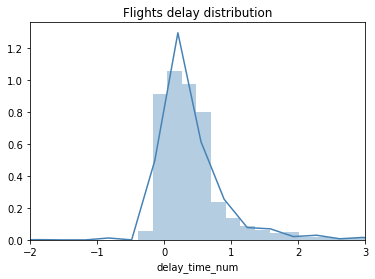

In [37]:
# focus on the center of the distribution
g = sns.distplot(flights[flights['cancelled'] == 0]['delay_time_num'], bins = 200, color = 'steelblue')
g.set(xlim=(-2, 3)) 
fig = plt.title("Flights delay distribution")

The distribution is not fully bell-shapped with a rather cut left tail and a longer right tail. We nevertheless do not observe significant outliers oe peculiarities.

We will create buckets to categorize the delay.

In [38]:
def delay_bucket(time):
    """"bucket time to differenciate minor, moderate and high delays"""
    if time <= 0.2: # less than 12 minutes
        return "on time"
    elif 0.2 < time < 3: # less than 3 hours
        return "some delay"
    else:
        return "claimed" # includes cancelled flights

In [39]:
flights['delay_time_bucket'] = flights['delay_time_num'].map(delay_bucket)
flights['delay_time_bucket'] = flights['delay_time_bucket'].astype('category')

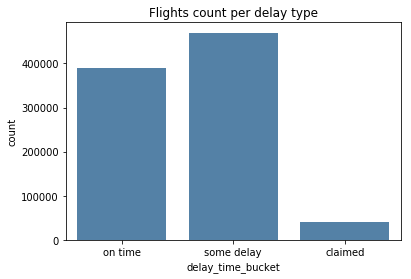

In [40]:
order = ['on time', 'some delay', 'claimed']
sns.countplot(x='delay_time_bucket', order = order, data=flights, color = 'steelblue')
fig = plt.title("Flights count per delay type")

More than half of the flights experience delay. A delay higher than 3 hours leading to claims remains moderate though as seen previously.

### Time data

#### a) Period of the day

Dividing the day into 4 periods will ease the analysis and could help the generalization of the model.

In [41]:
def period_day(hour):
    """Bucketize the day into 4 periods."""
    if (hour >= 0 and hour < 6):
        return "night"
    elif (hour >= 6 and hour < 12):
        return "morning"
    elif (hour >= 12 and hour < 18):
        return "afternoon"
    else:
        return "evening"

In [42]:
flights['period'] = flights['std_hour'].apply(period_day)
flights['period'] = flights['period'].astype('category')

#### b) Working days

We will create a new fields having date type to extract working days and help analysis.

In [43]:
# Merge 'std_hour' and 'flight_date' into one date column. Also create 'month' and 'day' features
flights['flight_date'] = flights['flight_date'].astype('datetime64[ns]')
flights['date'] = flights['flight_date'] + pd.to_timedelta(flights['std_hour'], unit='H')
flights['weekday'] = flights['date'].dt.dayofweek
flights['weekday'] = flights['weekday'].astype('category')
flights['month'] = flights['date'].dt.month
flights['month'] = flights['month'].astype('category')
flights['day'] = flights['date'].dt.day
flights['day'] = flights['day'].astype('category')

In [44]:
def week_end(x):
    """create one categorical field weekend"""
    day = x.weekday()
    if (day < 5):
        return 0
    else:
        return 1

In [45]:
flights['weekend'] = flights['date'].apply(week_end)
flights['weekend'] = flights['weekend'].astype('category')

The following will add Hong Kong bank holidays to eventually create a 'not_worked' feature (including Saturdays).

In [46]:
HK_bank_holidays = ['1-1','3-30','3-31','4-1','4-5','5-1','5-22','6-18','7-1','9-25','10-1','10-17','12-25','12-26']

def bank_holiday(date):
    """helper function to determine whether a date falls on a bank holiday"""
    if (date in HK_bank_holidays):
        return 1
    else:
        return 0

flights['date_key'] = flights['month'].astype(str) + "-" + flights['day'].astype(str) # month-day to match bank holidays  
flights['not_worked'] = flights['date_key'].map(bank_holiday) + flights['weekend']

def not_worked(day):
    """helper function to regularize 'not worked to 0/1 values"""
    if day > 0:
        return 1
    else:
        return 0
    
flights['not_worked'] = flights['not_worked'].map(not_worked)

#### Let's proceed now to analysis through different axis.

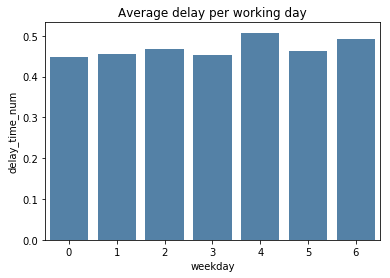

In [47]:
deptime_grouped = flights.groupby('weekday').mean()
sns.barplot(x=deptime_grouped.index, y ="delay_time_num", data=deptime_grouped, color = 'steelblue')
fig = plt.title("Average delay per working day")

The day of the week shows some impact on the delay.

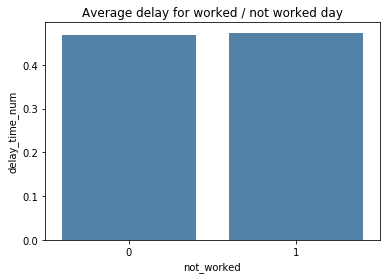

In [48]:
deptime_grouped = flights.groupby('not_worked').mean()
sns.barplot(x=deptime_grouped.index, y ="delay_time_num", data=deptime_grouped, color = 'steelblue')
fig = plt.title("Average delay for worked / not worked day")

Weekends and bank holiday do not seem to generate more (or less) delay

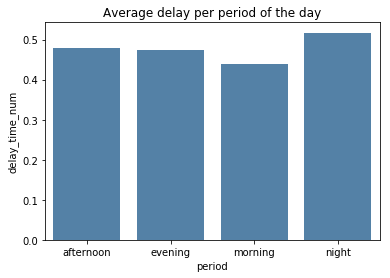

In [49]:
deptime_grouped = flights.groupby('period').mean()
sns.barplot(x=deptime_grouped.index, y ="delay_time_num", data=deptime_grouped, color = 'steelblue')
fig = plt.title("Average delay per period of the day")

Period of the day also seems quite impactful on the delay

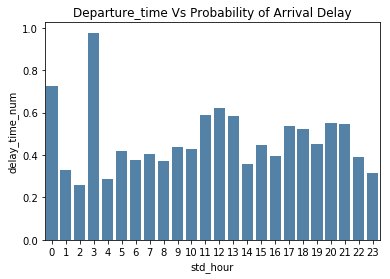

In [50]:
deptime_grouped = flights.groupby('std_hour').mean()
sns.barplot(x=deptime_grouped.index, y ="delay_time_num", data=deptime_grouped, color = 'steelblue')
fig = plt.title("Departure_time Vs Probability of Arrival Delay")

The hour will definitely help to predict delays.

#### Analysis on airlines

Let's look at the ratio of claimed flights to detect companies doing very well (or bad).

In [51]:
flights_airline = pd.DataFrame(pd.crosstab(flights['is_claim'],
                               flights['Airline']).apply(lambda r: r/r.sum(),axis=0).T.iloc[:,1].sort_values(ascending=False))
flights_airline.reset_index(inplace = True)
flights_airline.rename(columns={800:"ratio"},inplace = True)

,Airline,ratio
0,BO,1.000000
1,HB,1.000000
2,P7,1.000000
3,O3,0.909091
4,SV,0.750000
5,BG,0.747253
6,E8,0.331507
7,O8,0.326787
8,PK,0.291667
9,LV,0.275449


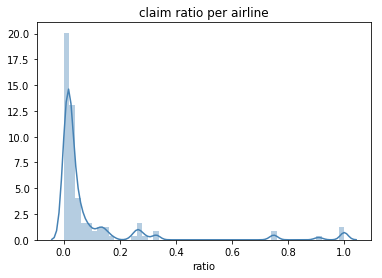

In [52]:
sns.distplot(flights_airline['ratio'], color = 'steelblue')
fig = plt.title("claim ratio per airline")
flights_airline.head(10)

6 companies have a ratio of claims higher than 0.74. We also see quite a few companies between 0.2 and 0.3. Airlines will help to predict delays and claims.

### Check on cancelled flights - typhoon model

Cancelled: 2.86% flights is cancelled.


0      859129
800     39403
Name: is_claim, dtype: int64

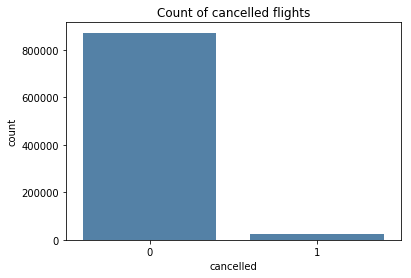

In [53]:
sns.countplot(x='cancelled',data=flights, color = 'steelblue')
fig = plt.title("Count of cancelled flights")
print("Cancelled: {:3.2f}% flights is cancelled.".format(((flights['cancelled'] == 1)*1).mean()*100))


flights['is_claim'].value_counts() # numerical view of the counts

Almost 3% of the flights are cancelled.

The percentage is quite low, but we will try to add predictors for this this type of event. We already have new indicators for the time (period, weekdays, worked days...) and we have airlines as well as geographical indicators.

We will see to help the modelling by adding the possible effect of typhoon in Hong Kong. This type of rare event lead inevitably to cancellations.

#### Model to predict typhoons

Although not directly inferred from obeservations, Typhoons in Hong Kong are an obvious major cause of delays and cancellations. 

We will use the historical data from the [Hong Kong Observatory](https://www.hko.gov.hk/contentc.htm) to predict typhoons.
Data is sparse since typhoons are not frequent. We will use a 50-year window to retrieve enough information.
We will not weigh earlier years as there is no clear trend, upwards or dowwardsn, of the change in number of typhoons year over year.

We will take the day and discard the exact time of the day. Such a granularity is not realistic.

In [54]:
import html5lib

column_typhoon = ['intensity','name','signal','begin_hour','begin_date','end_hour','end_date']
url = 'https://www.hko.gov.hk/cgi-bin/hko/warndb_e1.pl?opt=1&sgnl=1.or.higher&start_ym=197608&end_ym=201608&submit=Submit+Query'
typhoon50 = pd.read_html(url, skiprows = 11)[0].iloc[:586,:7]
typhoon50.columns = column_typhoon
typhoon50['signal'].replace(['8 NW', '8 SW', '8 NE', '8 SE'], ['5','6','7','8'] ,inplace = True) # formal HK scale
typhoon50 = typhoon50[['signal','begin_date']]

In [55]:
typhoon50.head(3)

,signal,begin_date
0,1,05/Aug/1976 S
1,3,05/Aug/1976 S
2,8,06/Aug/1976 S


Note: "S" in the date field indicates HK time + 1. In our case we will just take the day, so there is no impact.

In [56]:
typhoon50['begin_date'] = typhoon50['begin_date'].str.extract(r'(\d{2}/\w{3}/\d{4})') # remove S

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


We will create a key month-day with the average signal over the years and to prepare the join with the flights dataframe.

In [57]:
typhoon50['signal'] = typhoon50['signal'].astype('int8')

typhoon50['begin_date'] = pd.to_datetime(typhoon50['begin_date'], format='%d/%b/%Y', errors='coerce').astype('datetime64[ns]')

typhoon50['month'] = typhoon50['begin_date'].dt.month
typhoon50['day'] = typhoon50['begin_date'].dt.day

typhoon50_group = typhoon50.groupby(['month', 'day'])['signal'].mean() / (40*365+10*366) # average over 50 years with leap years
typhoon50 = typhoon50_group.reset_index() 
typhoon50['signal'] = typhoon50['signal'] / np.max(typhoon50['signal'])

typhoon50['key'] = typhoon50['month'].astype(str) + '-' + typhoon50['day'].astype(str)
typhoon50.drop(columns = ['month', 'day'], inplace = True)

We will join typhoon50 with flights. For performance purpose, we will take as few columns as possible from flights to do the join, then recreate the whole dataframe.

Let's finally export typhoon50 as csv for later use in our web app.

In [58]:
#typhoon50.to_csv('typhoon50.csv', index = False)

In [59]:
flights['month'] = flights['date'].dt.month
flights['day'] = flights['date'].dt.day
flights['key'] = flights['month'].astype(str) + '-' + flights['day'].astype(str)

flights = flights.merge(typhoon50, how='left', left_on ='key', right_on = 'key' )

flights['signal'].fillna(0, inplace = True)
flights.rename(columns={"key": "month-day"}, inplace = True)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


**Conclusion** We have a new feature giving a probability of typhoon which will help predict cancellations but also delays.

## Conclusion

We are ready to build the predictive model. We have
- analyzed the dataset
- cleaned the necessary fields
- peformed feature engineering
- added external data

We will begin the next phase by selecting relevant features, notably removing all the features that are useless, removing delay-related fields which will not have for future predictions and finally isolate the target is_claim feature.

# Modelling

I will use a twofold approach:
- predict whether a claim is raised or not. The output will 1/0 and a probability associated to it
- reuse the obtained probability to optimize the amount that should be allocated to each flight

## Claim prediction

In [60]:
final_data = flights # to leave flights as it is an manipulate another dataset

In [61]:
final_data.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim', 'cancelled',
       'delay_time_num', 'departure_latitude', 'departure_longitude', 'name',
       'country', 'airport_code', 'arrival_latitude', 'arrival_longitude',
       'distance', 'distance_group', 'delay_time_bucket', 'period', 'date',
       'weekday', 'month', 'day', 'weekend', 'date_key', 'not_worked',
       'month-day', 'signal'],
      dtype='object')

We will select only relevant features for the modelling.

In [62]:
final_data.head(1)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,...,period,date,weekday,month,day,weekend,date_key,not_worked,month-day,signal
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,...,morning,2016-07-01 10:00:00,4,7,1,0,7-1,1,7-1,0.315789


In [63]:
features = ['Airline','weekday', 'Week','std_hour','period', 'country', 'arrival_latitude',
            'arrival_longitude','distance', 'distance_group', 'not_worked', 'signal']
final_data_input = final_data[features]
final_data_output = final_data['is_claim'] / 800 # to normalize between 0 and 1

#### Data conversion

In [64]:
final_data_input.dtypes

Airline              category
weekday              category
Week                 category
std_hour                 int8
period               category
country                object
arrival_latitude      float64
arrival_longitude     float64
distance              float64
distance_group       category
not_worked              int64
signal                float64
dtype: object

In [65]:
for field in ['Airline','weekday','Week','std_hour','period','country','distance_group', 'not_worked']:
    final_data_input[field] = final_data_input[field].astype('category')

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
final_data_input.dtypes

Airline              category
weekday              category
Week                 category
std_hour             category
period               category
country              category
arrival_latitude      float64
arrival_longitude     float64
distance              float64
distance_group       category
not_worked           category
signal                float64
dtype: object

#### Convert categorical features into dummy variables for modelling purpose

In [67]:
categories = ['Airline', 'weekday', 'Week', 'std_hour', 'period', 'country', 'not_worked', 'distance_group']
non_categories = ['arrival_latitude','arrival_longitude','distance','signal']

flights_cat = pd.get_dummies(final_data_input[categories])
flights_non_cat = final_data_input[non_categories]

final_data_input = pd.concat([flights_cat, flights_non_cat], axis = 1)
final_data_features = final_data_input.columns
final_data_df = pd.concat([final_data_input, final_data_output], axis = 1)
final_data_df_features = final_data_df.columns
final_data_df['is_claim'] = final_data_df['is_claim'].astype('category')
final_data_df.shape

(898532, 271)

### Modeling preparation

**Important note**: grid searches have been commented to avoid very long running time. Only the result has been kept. Feel free to comment cells out if you wish to run the searches.

We will build our model with scikit learn

In [68]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We will create a mask to split the dataset between training and testing sets.

In [69]:
my_length = final_data_df.shape[0]
my_train, my_test = train_test_split(range(my_length), train_size=0.7)
mask=np.ones(my_length, dtype='int')
mask = mask.astype('int')
mask[my_train]=1
mask[my_test]=0
mask = (mask==1)

We will build a function that will take a model, perform grid search on the chosen dataset and return the best model. The 2 following functions have been adapted from works by [Anushadevi Mohan](https://github.com/anushamohan) who is a data sientist.

In [70]:
def model_optimize_grid(clf, parameters, X, y, n_jobs=2, n_folds=6, score_func=None):
    """Optimize model using grid search"""
    if score_func:
        grid_search = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        grid_search = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    grid_search.fit(X, y)
    print("Optimum model", grid_search.best_params_, grid_search.best_score_, grid_search.grid_scores_)
    optimum = grid_search.best_estimator_
    return optimum

We will also have a function to assess model performance.

Note with save the model with pickle for further use in our web app.

In [71]:
def do_classify(clf, parameters, df, featurenames, targetname, target, mask=None, score_func=None, n_folds=6, n_jobs=2):
    """calculates accuracy on the chosen train and test sets, return confusion matrix and best model"""
    subdf=df[featurenames]
    X=subdf.values
    y=(df[targetname].values==target)*1
    if list(mask) !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = model_optimize_grid(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    
    pickle.dump(clf, open("model.pkl","wb")) # serialize the model for later use.
    
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ("")
    return clf, Xtrain, ytrain, Xtest, ytest

We will choose logistic regression and random forest models to handle large number of parameters and have a probability associated to the 0/1 outcome so that we can further optimize the model with theses probabilities.

## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression

We first perform a grid search on C.

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [73]:
#clflog, X_train_lr, y_train_lr, X_test_lr, y_test_lr = do_classify(LogisticRegression(penalty = "l2"), 
#                                                       {"C": [0.00001, 0.0001, 0.001, 0.01, 0.1]},
#                                                       final_data_df, final_data_features, "is_claim", 1, mask=mask)

We will then try l1 for the penalty

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [74]:
#clflog, X_train_lr, y_train_lr, X_test_lr, y_test_lr = do_classify(LogisticRegression(penalty = "l1"), 
#                                                       {"C": [0.00001]},
#                                                       final_data_df, final_data_features, "is_claim", 1, mask=mask)

**Conclusion** Both penalty lead to the same model. We will choose l2 and C = 0.00001 for our Logistic Regression.

In [75]:
clflog, X_train_lr, y_train_lr, X_test_lr, y_test_lr = do_classify(LogisticRegression(penalty = "l2"), {"C": [0.00001]},
                                                       final_data_df, final_data_features, "is_claim", 1, mask=mask)

using mask
Optimum model {'C': 1e-05} 0.9562206266733654 [mean: 0.95622, std: 0.00000, params: {'C': 1e-05}]

Accuracy on training data: 0.96
Accuracy on test data:     0.96
[[257693      0]
 [ 11867      0]]



In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test_lr,clflog.predict(X_test_lr)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98    257693
          1       0.00      0.00      0.00     11867

avg / total       0.91      0.96      0.93    269560



C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Conclusion** The model forecasts that no claim will happen. As expected, the imbalance in the dataset leads to an overprediction of no claim.

## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

We will perform a succession of grid search on mutiple parameters to find the best model. The strategy will consist in doing a large search first, then focussing on the interval around the result of the large search.

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [78]:
#clfForest = RandomForestClassifier()
#parameters = {"n_estimators": list(range(20,101,10))}
#clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, final_data_df, final_data_features,
#                                                      'is_claim', target = 1, mask=mask, n_jobs = 2, score_func='accuracy')

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [79]:
#clfForest = RandomForestClassifier()
#parameters = {"n_estimators": list(range(25,35,1))}
#clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, final_data_df, final_data_features,
#                                                      'is_claim', target = 1, mask=mask, n_jobs = 2, score_func='accuracy')

We will choose 30 estimators and optimize max_depth

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [80]:
#clfForest = RandomForestClassifier()
#parameters = {"n_estimators": list(range(30-2, 30+2, 2)) , "max_depth" : list(range (20, 35 , 1))}
#clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, final_data_df, final_data_features,
#                                                      'is_claim', target = 1, mask=mask, n_jobs = 2, score_func='accuracy')

n_estimators: 28

max_depth: 25

Search on min_samples_split

**Warning** Heavy computation. Uncomment and run only if mandatory.

In [81]:
#clfForest = RandomForestClassifier()
#parameters = {"n_estimators": list(range(30-2, 30+2, 1)) , "max_depth" : list(range(25-2, 25+2, 1)), 
#              "min_samples_split": list(range(2,15,1))}
#clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, final_data_df, final_data_features,
#                                                      'is_claim', target = 1, mask=mask, n_jobs = 2, score_func='accuracy')

n_estimators: 28

max_depth: 25
    
min_samples_split: 5

**Final model**

In [82]:
clfForest = RandomForestClassifier()
parameters = {"n_estimators": [28] , "max_depth" : [25], "min_samples_split": [5]}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, final_data_df, final_data_features,
                                                      'is_claim', target = 1, mask=mask, n_jobs = 2, score_func='accuracy')

using mask
Optimum model {'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 28} 0.8003472332631659 [mean: 0.80035, std: 0.17196, params: {'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 28}]

Accuracy on training data: 0.96
Accuracy on test data:     0.96
[[257627     66]
 [ 11372    495]]



In [83]:
print(classification_report(ytest,clfForest.predict(Xtest)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98    257693
          1       0.88      0.04      0.08     11867

avg / total       0.95      0.96      0.94    269560



This model performs better than the logistic regression although the tendency to overpredict no claim remains.

## ROC curve

ROC curve code adapated from [towardsdatascience](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) website.

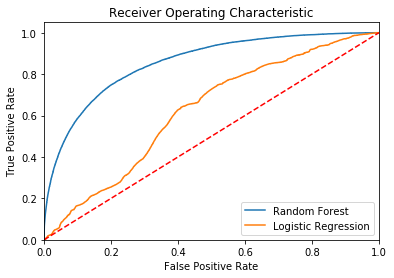

In [84]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(ytest, clfForest.predict(Xtest))
fpr, tpr, thresholds = roc_curve(ytest, clfForest.predict_proba(Xtest)[:,1])

logit_roc_auc_lr = roc_auc_score(y_test_lr, clflog.predict(X_test_lr))
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, clflog.predict_proba(X_test_lr)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

**Conclusion** Random Forest indeed is better. We will proceeed with this model for the second part of the modelling.

## Top features - Random Forest

We will look at the top predictors explaining claims

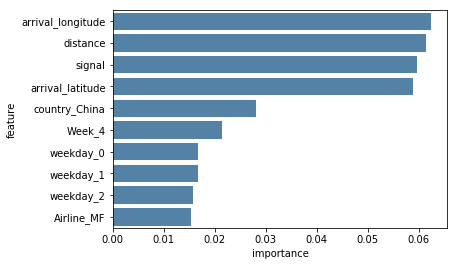

In [85]:
top_predictors = pd.DataFrame(list(zip(final_data_features, clfForest.feature_importances_)), columns=["feature", "importance"])
top_predictors.sort_values(["importance"], ascending = False, inplace = True)
top_predictors = top_predictors[:10]
sns.barplot(x="importance", y="feature", data=top_predictors, color = 'steelblue')

We can draw several conclusions out of the most significant features:
- distance + latitude + longitude (which determines uniquely) a place is a strong feature
- China flights have a lot of delay as seen on the map
- week 4 has impact because... this is Chinese New Year!
- the signal probability has some power. Good job!

## Second-step modelling: budget allocation using model probabilities

Now that we have the prediction claimed / not claimed, we will allocate a monetary value to cover potential delay.

The objective is to allocate little money to flights which are likely to be on time and more to flights that are usually late.

We will use the output claim probability for each flights given by the model and, on this basis, will allocate a certain amount to flights having this output probability.

Let's first build a dataframe to look at the probability of claims output by the model.

In [120]:
y_predict_prob = pd.DataFrame(clfForest.predict_proba(Xtrain), columns=['prob_not_claimed','prob_claimed'])
y_predict = pd.DataFrame({'y_predict': clfForest.predict(Xtrain)})
y_true = pd.DataFrame({'y_true': ytrain})

data_output = pd.concat([y_true, y_predict, y_predict_prob], axis=1)
data_output['y_gap'] = data_output['y_true'] - data_output['y_predict']
data_output = data_output[['y_true', 'y_predict', 'y_gap', 'prob_not_claimed', 'prob_claimed']]
allocated_amount = 800
data_output['budgetted'] = data_output['y_predict'] * allocated_amount
data_output['paid'] = data_output['y_true'] * allocated_amount
data_output['Q1'] = abs(data_output['budgetted'] - data_output['paid'])
data_output['Q2'] = abs(data_output['budgetted'] - data_output['paid'])**2
data_output.head(3)

,y_true,y_predict,y_gap,prob_not_claimed,prob_claimed,budgetted,paid,Q1,Q2
0,0,0,0,0.989221,0.010779,0,0,0,0
1,0,0,0,0.956342,0.043658,0,0,0,0
2,0,0,0,0.973528,0.026472,0,0,0,0


Let's calculate Q1 and Q2 (metrics to optimize) with 0 / 800 allocated respectively predicted not claimed / predicted claimed

In [121]:
data_output[data_output['y_gap'] != 0][['Q1','Q2']].sum(axis=0) / data_output.shape[0]

Q1       32.912117
Q2    26329.693532
dtype: float64

And the average

In [122]:
print("mean(Q1,Q2):")
data_output[data_output['y_gap'] != 0][['Q1','Q2']].sum(axis=0).mean() / data_output.shape[0]

mean(Q1,Q2):


13181.302824291066

Let's look at y_gap to detect wrong predictions:
- +1 is a not predicted claim
- -1 is a wrongly predicted claim
-  0 is a correct prediction 

In [123]:
data_output['y_gap'].value_counts()

 0    603096
 1     25847
-1        29
Name: y_gap, dtype: int64

We will handle both cases, 1 and -1, separately. Let's begin with y_gap = 1 and repeat the same for y_gap = -1.

#### Unpredicted claims

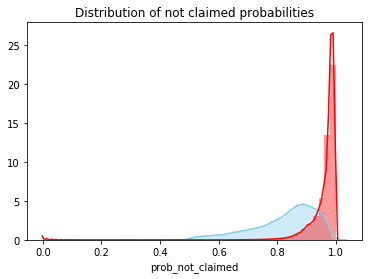

In [124]:
sns.distplot(data_output[data_output['y_gap'] == 1]['prob_not_claimed'] , color="skyblue", label="Not budgetted claim")
sns.distplot(data_output[data_output['y_gap'] == 0]['prob_not_claimed'] , color="red", label="Correctly budgetted claim")
fig = plt.title("Distribution of not claimed probabilities")

In order to optimize the average of Q1 and Q2, we cannot leave only 0 and 800 values because the square of the difference for mistaken predictions is the highest, thus impacting badly Q2.

We therefore need to ponder the budget depending on the number of observed values for each probability.

Let's build first a dataframe only for proabilities higher than 0.5.

In [125]:
data_output_bucket_1 = data_output[data_output['prob_not_claimed'] >= 0.5] # we are interested in probas over the 0.5 cutoff.
data_output_bucket_1['binned'] = round(data_output_bucket_1['prob_not_claimed'], 2) # 0.01 bucket size to have enough data.
data_output_bucket_1.head(3)

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,y_true,y_predict,y_gap,prob_not_claimed,prob_claimed,budgetted,paid,Q1,Q2,binned
0,0,0,0,0.989221,0.010779,0,0,0,0,0.99
1,0,0,0,0.956342,0.043658,0,0,0,0,0.96
2,0,0,0,0.973528,0.026472,0,0,0,0,0.97


Let's look now at the number of records per bucket

In [126]:
budget_df_1 = data_output_bucket_1.groupby(['binned','y_gap'])['prob_not_claimed'].agg(['count']).fillna(0)
budget_df_1 = budget_df_1.unstack().fillna(0)
budget_df_1 = pd.DataFrame(budget_df_1.values, index = budget_df_1.index)
budget_df_1.head(3)

,0,1
binned,,
0.50,5.0,39.0
0.51,8.0,107.0
0.52,7.0,97.0


Our goal is to optimize the average of Q1 and Q2. We have 2 columns:
- '0' means correctly predicted not claimed 
- '1' means incorrectly predicted not claimed

We want to find the budget that will minimize:

**Q1 + Q2 = ( n(0) x (0-budget) + n(1) x (800-budget) ) + ( n(0) x (0-budget)^2 + n(1) x (800-budget)^2 )**

where n(0) and n(1) are respectively the number of unclaimed and claimed flights. 

This is a polynomial of degree 2 which has for solution:

**( n(0) + 1600 x n(1) ) / ( 2 x( n(0) + n(1) ) )**

In [127]:
budget_df_1['budget'] = round((budget_df_1[0] + 1600 * budget_df_1[1]) / (2*(budget_df_1[0] + budget_df_1[1])),2)

In [128]:
pd.DataFrame(budget_df_1['budget']).tail(10)

,budget
binned,
0.91,66.39
0.92,55.88
0.93,43.52
0.94,32.43
0.95,24.12
0.96,15.99
0.97,7.53
0.98,1.71
0.99,0.64


The higher the probability, the lower the budget. Correct!

Slight caveat: we may want to set the last probability budget at 0 for consistency purpose.

In [129]:
budget_df_1['budget'][1.00] = 0 # Done!

#### Uncorrectly predicted as claimed

We will apply the same rationale working again with prob_not_claimed.

In [130]:
data_output_bucket_2 = data_output[data_output['prob_not_claimed'] < 0.5]
data_output_bucket_2['binned'] = round(data_output_bucket_2['prob_not_claimed'], 2)
budget_df_2 = data_output_bucket_2.groupby(['binned','y_gap'])['prob_not_claimed'].agg(['count']).fillna(0)
budget_df_2 = budget_df_2.unstack().fillna(0)
budget_df_2 = pd.DataFrame(budget_df_2.values, index = budget_df_2.index)
budget_df_2['budget'] = round(800 * budget_df_2[1] / (budget_df_2[0] + budget_df_2[1]),2)

C:\Users\BXPR8107\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Good! Let's now concatenate the 2 dataframes and finally clean it.

In [131]:
budget_df_2 = budget_df_2.drop(0.5) # remove duplicate lines due to rounding
budget_df_2.loc[0.07,'budget'] = 800 # correct value caused by sparse data
df_add_1 = pd.DataFrame({0:[0], 1:[0], 'budget':[800]}, index = [0.13]) # missing proba due to few data
df_add_2 = pd.DataFrame({0:[0], 1:[0], 'budget':[800]}, index = [0.17]) # missing proba due to few data
budget_df_2 = pd.concat([budget_df_2, df_add_1, df_add_2])
budget_df_2 = budget_df_2.reset_index().rename(columns={"index": "binned"}).sort_values('binned').set_index('binned')
budget_df = pd.concat([budget_df_2, budget_df_1]) # concatenate both dataframes
budget_df.drop(columns=[0, 1], inplace = True)

We will also save budget_df as a csv for our online model.

In [132]:
#budget_df.to_csv("budget_df.csv") DO NOT UNCOMMENT This csv file will used for the online model

Let's recalculate Q1 and Q2 with this change.

In [133]:
def budget_mapper(prob):
    """associate budget to prob_not_claimed probability"""
    prob = round(prob,2)
    return budget_df['budget'][prob]

In [134]:
y_predict_prob = pd.DataFrame(clfForest.predict_proba(Xtrain), columns=['prob_not_claimed','prob_claimed'])
y_predict = pd.DataFrame({'y_predict': clfForest.predict(Xtrain)})
y_true = pd.DataFrame({'y_true': ytrain})

data_output = pd.concat([y_true, y_predict, y_predict_prob], axis=1)
data_output['y_gap'] = data_output['y_true'] - data_output['y_predict']
data_output = data_output[['y_true', 'y_predict', 'y_gap', 'prob_not_claimed', 'prob_claimed']]
allocated_amount = 800

data_output['budgetted'] = y_predict_prob['prob_not_claimed'].map(budget_mapper) # map the proba to budget

data_output['paid'] = data_output['y_true'] * allocated_amount
data_output['Q1'] = abs(data_output['budgetted'] - data_output['paid'])
data_output['Q2'] = abs(data_output['budgetted'] - data_output['paid'])**2

In [135]:
data_output[data_output['y_gap'] == 1][['Q1','Q2']].sum(axis=0) / data_output.shape[0]

Q1       22.418290
Q2    14027.469355
dtype: float64

In [136]:
print("mean(Q1,Q2):")
data_output[data_output['y_gap'] != 0][['Q1','Q2']].sum(axis=0).mean() / data_output.shape[0]

mean(Q1,Q2):


7038.3557138931055

We have optimized the model on the training set. Let's assess now on the test set.

### performance on test set without price adjustment

In [137]:
y_predict_prob = pd.DataFrame(clfForest.predict_proba(Xtest), columns=['prob_not_claimed','prob_claimed'])
y_predict = pd.DataFrame({'y_predict': clfForest.predict(Xtest)})
y_true = pd.DataFrame({'y_true': ytest})

data_output = pd.concat([y_true, y_predict, y_predict_prob], axis=1)
data_output['y_gap'] = data_output['y_true'] - data_output['y_predict']
data_output = data_output[['y_true', 'y_predict', 'y_gap', 'prob_not_claimed', 'prob_claimed']]
allocated_amount = 800
data_output['budgetted'] = data_output['y_predict'] * allocated_amount
data_output['paid'] = data_output['y_true'] * allocated_amount
data_output['Q1'] = abs(data_output['budgetted'] - data_output['paid'])
data_output['Q2'] = abs(data_output['budgetted'] - data_output['paid'])**2

In [138]:
data_output[data_output['y_gap'] == 1][['Q1','Q2']].sum(axis=0) / data_output.shape[0]

Q1       33.749815
Q2    26999.851610
dtype: float64

In [139]:
print("mean(Q1,Q2):")
data_output[data_output['y_gap'] != 0][['Q1','Q2']].sum(axis=0).mean() / data_output.shape[0]

mean(Q1,Q2):


13595.248553197804

### performance on test set with price adjustment

In [140]:
y_predict_prob = pd.DataFrame(clfForest.predict_proba(Xtest), columns=['prob_not_claimed','prob_claimed'])
y_predict = pd.DataFrame({'y_predict': clfForest.predict(Xtest)})
y_true = pd.DataFrame({'y_true': ytest})

data_output = pd.concat([y_true, y_predict, y_predict_prob], axis=1) 
data_output['y_gap'] = data_output['y_true'] - data_output['y_predict']
data_output = data_output[['y_true', 'y_predict', 'y_gap', 'prob_not_claimed', 'prob_claimed']]
allocated_amount = 800

data_output['budgetted'] = y_predict_prob['prob_not_claimed'].map(budget_mapper) # map the proba and budget

data_output['paid'] = data_output['y_true'] * allocated_amount
data_output['Q1'] = abs(data_output['budgetted'] - data_output['paid'])
data_output['Q2'] = abs(data_output['budgetted'] - data_output['paid'])**2

In [141]:
data_output[data_output['y_gap'] == 1][['Q1','Q2']].sum(axis=0) / data_output.shape[0]

Q1       26.289880
Q2    17973.744146
dtype: float64

In [142]:
print("mean(Q1,Q2):")
data_output[data_output['y_gap'] != 0][['Q1','Q2']].sum(axis=0).mean() / data_output.shape[0]

mean(Q1,Q2):


9073.810682310826

Better indeed! Even better than the training set.

### Conclusion

We have completed our model which now thinly allocate a budget on future flights to cater with potential delays.

## Try it yourself!

This section is made for you to upload your own dataset and predict the amount to allocate.

### How-to

1. Place your csv file in the same folder as this notebook
2. Substitute "name_file" in the last cell of the notebook function by "your_file" in a csv format with the following columns in the same format as in the flights_delay_data.csv file:
    - 'flight_id'
    - 'flight_no'
    - 'Week'
    - 'Departure' (must be "HKG")
    - 'Arrival'
    - 'Airline'
    - 'std-hour'
    - 'flight_date'
3. Uncomment the cell   
4. Run the cell
5. Retrieve the created "your_file_output.csv" in the same folder

#### Helper functions to test input correctness

In [143]:
# We will explicit the list to check the validity of input in order to use the same for the web app

right_columns = ['flight_id','flight_no','Week','Departure','Arrival','Airline','std_hour','flight_date']  
right_formats = [np.int64,'object',np.int64,'object','object','object',np.int64,'object']

airports_list = ['KIX', 'TNN', 'MNL', 'SIN', 'PEK', 'IST', 'HGH', 'KUL', 'BLR',
       'MXP', 'SYD', 'TPE', 'MEL', 'SGN', 'NRT', 'CNX', 'AKL', 'BKK',
       'HND', 'PVG', 'LHR', 'CTU', 'NGB', 'HAK', 'SHA', 'ICN', 'NGO',
       'DXB', 'LAX', 'HKT', 'HAN', 'KHN', 'CSX', 'DPS', 'NKG', 'CGK',
       'BKI', 'KHH', 'CEB', 'RMQ', 'JNB', 'BWN', 'OKA', 'PEN', 'USM',
       'PUS', 'CCU', 'DEL', 'WUH', 'FUK', 'MAA', 'CDG', 'CMB', 'JJN',
       'TAO', 'CKG', 'MAN', 'CJU', 'RGN', 'BNE', 'JFK', 'EWR', 'FRA',
       'HEL', 'CNS', 'SFO', 'XMN', 'ILO', 'ORD', 'ZRH', 'YVR', 'ADL',
       'BOM', 'KWE', 'PER', 'MLE', 'GUM', 'TSN', 'VVO', 'DOH', 'AUH',
       'KWL', 'AMS', 'TLV', 'YNZ', 'WUX', 'CTS', 'DMK', 'KMG', 'KOJ',
       'PNH', 'SYX', 'YYZ', 'YNT', 'CAN', 'BOS', 'CRK', 'SUB', 'WNZ',
       'FOC', 'DAC', 'CGO', 'ULN', 'AMM', 'REP', 'DFW', 'XIY', 'SVO',
       'ADD', 'DAD', 'TNA', 'SJW', 'KBV', 'NAN', 'NNG', 'DLC', 'KTM',
       'MUC', 'ZHA', 'FCO', 'RUH', 'MRU', 'YIW', 'HRB', 'SWA', 'SHE',
       'DUS', 'POM', 'LJG', 'OKJ', 'HFE', 'SEA', 'CXR', 'KLO', 'HIJ',
       'SPN', 'LYA', 'MXZ', 'WUS', 'XNN', 'HET', 'XUZ', 'OVB', 'ARN',
       'CGQ', 'LHW', 'IKT', 'KMJ', 'KCH', 'ALA', 'BAH', 'KMI', 'MAD',
       'NBO', 'ROR', 'YTY', 'DTW', 'ZYI', 'OOL', 'TAK', 'JHG', 'LGA']

airlines_list = ['UO', 'CX', 'NZ', 'AI', 'NH', 'GK', 'JL', 'QR', 'SA',
                 'MM', 'HX', 'LD', '9W', 'CI', 'PR', 'KA', '5J', 'Z2',
                 'DG', 'AY', 'TZ', 'SQ', 'AA', 'ET', 'TR', '3K', 'AC',
                 'S7', 'VA', 'UA', 'US', 'B6', 'TV', 'TT', 'HU', 'CA',
                 'CZ', 'BI', 'B5', 'TK', 'MU', 'FM', '9C', 'Y8', 'MH',
                 'WY', 'BA', 'EY', 'AK', 'MK', 'OD', 'OM', '7C', 'QF',
                 'VS', 'AF', 'BR', 'TG', 'HM', 'VN', 'LY', 'SV', 'DL',
                 'JW', 'NQ', 'FD', 'E8', 'LA', 'LH', 'PG', 'UL', 'MJ',
                 'O8', 'KQ', 'RJ', 'OX', 'EK', 'MD', 'OZ', 'PK', 'HO',
                 'JD', '3U', 'BL', 'VQ', 'KE', 'ZE', 'LJ', 'TP', '3V',
                 'SO', 'GA', 'SU', 'RI', 'JT', 'QG', 'AE', '2P', 'BX',
                 'KL', 'ZH', 'MF', 'UB', 'O3', 'LX', 'LV', 'HB', 'XF',
                 'HZ', 'AB', 'HG', 'JU', 'PQ', 'BG', 'FJ', 'RA', 'BO',
                 'PX', 'SK', 'KC', 'ED', 'P7']

hour_day = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

week_year = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52]

final_model_features = ['Airline_2P', 'Airline_3K', 'Airline_3U', 'Airline_3V',
       'Airline_5J', 'Airline_7C', 'Airline_9C', 'Airline_9W',
       'Airline_AA', 'Airline_AB', 'Airline_AC', 'Airline_AE',
       'Airline_AF', 'Airline_AI', 'Airline_AK', 'Airline_AY',
       'Airline_B5', 'Airline_B6', 'Airline_BA', 'Airline_BG',
       'Airline_BI', 'Airline_BL', 'Airline_BO', 'Airline_BR',
       'Airline_BX', 'Airline_CA', 'Airline_CI', 'Airline_CX',
       'Airline_CZ', 'Airline_DG', 'Airline_DL', 'Airline_E8',
       'Airline_ED', 'Airline_EK', 'Airline_ET', 'Airline_EY',
       'Airline_FD', 'Airline_FJ', 'Airline_FM', 'Airline_GA',
       'Airline_GK', 'Airline_HB', 'Airline_HG', 'Airline_HM',
       'Airline_HO', 'Airline_HU', 'Airline_HX', 'Airline_HZ',
       'Airline_JD', 'Airline_JL', 'Airline_JT', 'Airline_JU',
       'Airline_JW', 'Airline_KA', 'Airline_KC', 'Airline_KE',
       'Airline_KL', 'Airline_KQ', 'Airline_LA', 'Airline_LD',
       'Airline_LH', 'Airline_LJ', 'Airline_LV', 'Airline_LX',
       'Airline_LY', 'Airline_MD', 'Airline_MF', 'Airline_MH',
       'Airline_MJ', 'Airline_MK', 'Airline_MM', 'Airline_MU',
       'Airline_NH', 'Airline_NQ', 'Airline_NZ', 'Airline_O3',
       'Airline_O8', 'Airline_OD', 'Airline_OM', 'Airline_OX',
       'Airline_OZ', 'Airline_P7', 'Airline_PG', 'Airline_PK',
       'Airline_PQ', 'Airline_PR', 'Airline_PX', 'Airline_QF',
       'Airline_QG', 'Airline_QR', 'Airline_RA', 'Airline_RI',
       'Airline_RJ', 'Airline_S7', 'Airline_SA', 'Airline_SK',
       'Airline_SO', 'Airline_SQ', 'Airline_SU', 'Airline_SV',
       'Airline_TG', 'Airline_TK', 'Airline_TP', 'Airline_TR',
       'Airline_TT', 'Airline_TV', 'Airline_TZ', 'Airline_UA',
       'Airline_UB', 'Airline_UL', 'Airline_UO', 'Airline_US',
       'Airline_VA', 'Airline_VN', 'Airline_VQ', 'Airline_VS',
       'Airline_WY', 'Airline_XF', 'Airline_Y8', 'Airline_Z2',
       'Airline_ZE', 'Airline_ZH', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Week_1',
       'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7',
       'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13',
       'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18', 'Week_19',
       'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24', 'Week_25',
       'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30', 'Week_31',
       'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36', 'Week_37',
       'Week_38', 'Week_39', 'Week_40', 'Week_41', 'Week_42', 'Week_43',
       'Week_44', 'Week_45', 'Week_46', 'Week_47', 'Week_48', 'Week_49',
       'Week_50', 'Week_51', 'Week_52', 'std_hour_0', 'std_hour_1',
       'std_hour_2', 'std_hour_3', 'std_hour_4', 'std_hour_5',
       'std_hour_6', 'std_hour_7', 'std_hour_8', 'std_hour_9',
       'std_hour_10', 'std_hour_11', 'std_hour_12', 'std_hour_13',
       'std_hour_14', 'std_hour_15', 'std_hour_16', 'std_hour_17',
       'std_hour_18', 'std_hour_19', 'std_hour_20', 'std_hour_21',
       'std_hour_22', 'std_hour_23', 'period_afternoon', 'period_evening',
       'period_morning', 'period_night', 'country_Australia',
       'country_Bahrain', 'country_Bangladesh', 'country_Brunei',
       'country_Burma', 'country_Cambodia', 'country_Canada',
       'country_China', 'country_Ethiopia', 'country_Fiji',
       'country_Finland', 'country_France', 'country_Germany',
       'country_Guam', 'country_India', 'country_Indonesia',
       'country_Israel', 'country_Italy', 'country_Japan',
       'country_Jordan', 'country_Kazakhstan', 'country_Kenya',
       'country_Malaysia', 'country_Maldives', 'country_Mauritius',
       'country_Mongolia', 'country_Nepal', 'country_Netherlands',
       'country_New Zealand', 'country_Northern Mariana Islands',
       'country_Palau', 'country_Papua New Guinea', 'country_Philippines',
       'country_Qatar', 'country_Russia', 'country_Saudi Arabia',
       'country_Singapore', 'country_South Africa', 'country_South Korea',
       'country_Spain', 'country_Sri Lanka', 'country_Sweden',
       'country_Switzerland', 'country_Taiwan', 'country_Thailand',
       'country_Turkey', 'country_United Arab Emirates',
       'country_United Kingdom', 'country_United States',
       'country_Vietnam', 'not_worked_0', 'not_worked_1',
       'distance_group_1:<1000', 'distance_group_2:1000-1599',
       'distance_group_3:1000-2299', 'distance_group_4:2300-3499',
       'distance_group_5:>= 3500', 'arrival_latitude','arrival_longitude','distance','signal']

In [144]:
def file_checker(name_file):
    """succession of helper functions to check the file is in the right format
    This function is critical as it should stop the process if any error is detected"""

    # check that the file is a .csv and 
    name_file = str(name_file)
    if (name_file[-4:] != '.csv'):
        print("The file is not a '.csv'")
        return 0
    else:
        print("The file is a '.csv'")

    # load the csv into a pandas DataFrame
    try:
        future_flights = pd.read_csv(name_file)
        print("The dataset is loaded")        
    except:
        print("We could not load the file. Please check it.")
        return 0
    
    # check columns
    if len(future_flights.columns) != len(right_columns):
        print("The dataset does not have the same number of columns. Please check")
        return 0
    for i in range(len(right_columns)):
        if future_flights.columns[i] != right_columns[i]:
            print("The dataset does not have the same column names. Please check their names and order")
            print("We have detected the columns " + future_flights.columns.tolist())
            print("The columns should be " + right_columns)
            return 0
    print("The dataset has the right columns")
        
    # check format
    for i in range(len(right_formats)):    
        if future_flights[right_columns[i]].dtype != right_formats[i]:
            print("The dataset have type inconsistency")
            return 0
    print("The dataset has the right types in each column")
    
    # check number of lines
    print("The dataset has " + str(future_flights.shape[0]) + " records")
    
    # check null value for Airline column
    if not(future_flights['Airline'].isin(airlines_list).all()):
        airline_null = np.invert(future_flights['Airline'].isin(airlines_list)).sum()
        future_flights['Airline'].replace('NULL', 'CX', inplace = True)
        future_flights['Airline'].fillna('CX', inplace = True)
        print(str(airline_null) + " incorrect values have been detected in Airline. OK to continue.")        
    
    # check null values
    remaining_null = future_flights.isnull().sum().sum()
    if remaining_null != 0:
        print("The dataset has " + str(future_flights.isnull().sum().sum()) + " null value(s). Please review the data.")
        return 0
    else:
        print("The dataset has no blocking null value.")
        
    # specific column checker
    if (future_flights['Departure'] != 'HKG').any():
        print('There are Departures which are not Hong Kong. Please check.')
        return 0
    if not(future_flights['std_hour'].isin(hour_day).all()):
        print('There are standard hours out of the range [0-24]. Please check.')
        return 0        
    if not(future_flights['Week'].isin(week_year).all()):
        print('There are weeks out of the range [1-52]. Please check.')   
        return 0
    if not(future_flights['Arrival'].isin(airports_list).all()):
        print('Some arrivals are unknown. Please check.')   
        return 0
    if not(future_flights['Airline'].isin(airlines_list).all()):
        print('Some airlines are unknown. Please check.')
        return 0
        
    try:
        pd.to_datetime(flights['date'])
        print("Data checked completed...")
    except:
        print("Date column cannot be read. Please check.")        
        
    print("...the dataset is valid!")
    return 1

In [145]:
def transform_dataset(name_file):
    """preprocess the dataset to be able to apply prediction model"""
    flight_dataset = pd.read_csv(name_file)
    
    flight_dataset['flight_no'] = flight_dataset['flight_no'].astype('category')
    flight_dataset['Week'] = flight_dataset['Week'].astype('category')
    flight_dataset['Arrival'] = flight_dataset['Arrival'].astype('category')
    flight_dataset['Airline'] = flight_dataset['Airline'].astype('category')
    flight_dataset['std_hour'] = flight_dataset['std_hour'].astype('int8')
    
    flight_dataset['departure_latitude'] = airports[airports['airport_code'] == 'HKG']['latitude'].values[0]
    flight_dataset['departure_longitude'] = airports[airports['airport_code'] == 'HKG']['longitude'].values[0]
    flight_dataset = flight_dataset.merge(airports, left_on='Arrival', right_on='airport_code', how = 'inner')  
    flight_dataset.rename(columns={"latitude": "arrival_latitude", "longitude": "arrival_longitude"}, inplace = True)
    flight_dataset['distance'] = flight_dataset['Arrival'].map(airports_dict)
    
    flight_dataset['distance_group'] = flight_dataset['distance'].apply(distance_group_maker)
    flight_dataset['distance_group'] = flight_dataset['distance_group'].astype('category')
    
    flight_dataset['period'] = flight_dataset['std_hour'].apply(period_day)
    flight_dataset['period'] = flight_dataset['period'].astype('category')
    flight_dataset['date'] = pd.to_datetime(flight_dataset['flight_date'])
    flight_dataset['weekday'] = flight_dataset['date'].dt.dayofweek
    flight_dataset['weekday'] = flight_dataset['weekday'].astype('category')
    flight_dataset['month'] = flight_dataset['date'].dt.month
    flight_dataset['month'] = flight_dataset['month'].astype('category')
    flight_dataset['day'] = flight_dataset['date'].dt.day
    flight_dataset['day'] = flight_dataset['day'].astype('category')  
    flight_dataset['weekend'] = flight_dataset['date'].apply(week_end)
    
    flight_dataset['date_key'] = flight_dataset['month'].astype(str) + "-" + flight_dataset['day'].astype(str)
    flight_dataset['not_worked'] = flight_dataset['date_key'].map(bank_holiday) + flight_dataset['weekend']
    flight_dataset['weekend'] = flight_dataset['weekend'].astype('category')
    flight_dataset['not_worked'] = flight_dataset['not_worked'].map(not_worked)
    
    flight_dataset['key'] = flight_dataset['month'].astype(str) + '-' + flight_dataset['day'].astype(str)
    flight_dataset = flight_dataset.merge(typhoon50, how='left', left_on ='key', right_on = 'key')
    flight_dataset['signal'].fillna(0, inplace = True)
    flight_dataset.rename(columns={"key": "month-day"}, inplace = True)

    final_features = ['Airline','weekday', 'Week','std_hour','period', 'country', 'arrival_latitude',
            'arrival_longitude','distance', 'distance_group', 'not_worked', 'signal']
    flight_dataset = flight_dataset[final_features]
    for field in ['Airline','weekday','Week','std_hour','period','country','distance_group', 'not_worked']:
        flight_dataset[field] = flight_dataset[field].astype('category')  
    categories = ['Airline', 'weekday', 'Week', 'std_hour', 'period', 'country', 'not_worked', 'distance_group']
    non_categories = ['arrival_latitude','arrival_longitude','distance','signal']
    flights_cat = pd.get_dummies(flight_dataset[categories])
    flights_non_cat = flight_dataset[non_categories]
    flight_dataset = pd.concat([flights_cat, flights_non_cat], axis = 1)
    
    # Add the dummy variables that we created in scikit-learn and that may be missing from the new dataset
    missing_features = set(final_model_features) - set(flight_dataset.columns)
    for feature in missing_features:
        flight_dataset[feature] = 0 # create new features and set them to 0
        flight_dataset[feature] = flight_dataset[feature].astype('category')
    flight_dataset = flight_dataset[final_model_features] # reorder the columns

    print("")
    print("Processing budget...")
    return flight_dataset

In [146]:
def predict_dataset(name_file, processed_dataset):
    """calculate budget to allocate to each flight and return the value in a new column of the dataframe"""
    flight_dataset = pd.read_csv(name_file)
    flight_dataset['budget'] = pd.DataFrame(clfForest.predict_proba(processed_dataset))[0].map(budget_mapper)   
    return flight_dataset

In [147]:
def flight_predictor(name_file):
    output_name = name_file[:-4] + "_output.csv"
    flight_dataset = file_checker(name_file)
    if flight_dataset:
        flight_dataset_output = predict_dataset(name_file, transform_dataset(name_file)).to_csv(output_name, index = False)
        print("")
        print("... budget ready!")
        print("A csv file named " + str(output_name) + " with the budget figures is now in your folder.")
        print("Have a nice flight!")
        return 1
    else:
        print("An error occured")
        return 0

## Testing

You can find all the tests in the **Tests** folder file_checker.
10 files have been tested:
- 1_flights_sample_valid.csv
- 2_Book1_excel_NOT_valid.xlsx
- 3_flights_sample_more_columns_NOT_valid.csv
- 4_flights_sample_null_values_NOT_valid.csv
- 5_flights_sample_NULL_airline_valid.csv
- 6_flights_sample_not_HK_depart_NOT_valid.csv
- 7_flights_sample_impossible_time_NOT_valid.csv
- 8_flights_sample_fake_airline_NOT_valid.csv
- 9_flights_sample_fake_arrival_NOT_valid.csv
- 10_flights_sample_impossible_week_NOT_valid.csv

The name of each file explicits the type of test. 'NOT_valid' is correctly stopped durring the process while 'valid' correctly returns predictions.

All the tests have been successful. Feel free to uncomment the cells below to rerun them.

### How to rerun the tests

Take the files in the 'Tests' folder, put them into the same folder as the notebook, uncomment the tests you wish you try and run the cell(s).

In [ ]:
# flight_predictor("1_flights_sample_valid.csv")

In [ ]:
# flight_predictor("2_Book1_excel_NOT_valid.xlsx")

In [ ]:
# flight_predictor("3_flights_sample_more_columns_NOT_valid.csv")

In [ ]:
# flight_predictor("4_flights_sample_null_values_NOT_valid.csv")

In [ ]:
# flight_predictor("5_flights_sample_NULL_airline_valid.csv")

In [ ]:
# flight_predictor("6_flights_sample_not_HK_depart_NOT_valid.csv")

In [ ]:
# flight_predictor("7_flights_sample_impossible_time_NOT_valid.csv")

In [ ]:
# flight_predictor("8_flights_sample_fake_airline_NOT_valid.csv")

In [ ]:
# flight_predictor("9_flights_sample_fake_arrival_NOT_valid.csv")

In [ ]:
# flight_predictor("10_flights_sample_impossible_week_NOT_valid.csv")

## Try it yourself!

This section is made for you to upload your own dataset and predict the amount to allocate.

### How-to

1. Place your csv file in the same folder as this notebook
2. Substitute "name_file" in the last cell of the notebook function by "your_file" in a csv format with the following columns in the same format as in the flights_delay_data.csv file:
    - 'flight_id'
    - 'flight_no'
    - 'Week'
    - 'Departure' (must be "HKG")
    - 'Arrival'
    - 'Airline'
    - 'std-hour'
    - 'flight_date'
3. Uncomment the cell   
4. Run the cell
5. Retrieve the created "your_file_output.csv" in the same folder

## Uncomment, replace with your file name and run!

In [153]:
#flight_predictor("name_file.csv")